In [1]:
import torch
import torch_geometric
from torch_geometric.nn import radius_graph
from gns import data_loader
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from collections import defaultdict
import sys

/home/yjc/Documents/gns-2/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check `train.py` Created with MPM Results

In [3]:
data_path = "../gns-data/datasets/sand-2d/train.npz"
npz_data = np.load(data_path, allow_pickle=True)
for id, trajectory in npz_data.items():
    print(f'MPM trajectory ID: {id}')
    print(f'Position data of trajectory: {trajectory[0].shape}')
    print(f'Material type:{trajectory[1].shape}')

MPM trajectory ID: simulation_trajectory_0
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_1
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_2
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_3
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_4
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_5
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_6
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_7
Position data of trajectory: (320, 7200, 2)
Material type:(7200,)
MPM trajectory ID: simulation_trajectory_8
Position data of trajectory: (320, 4800, 2)
Material type:(4800,)


# See How torch `raius_graph` Works

All the nodes are conncected because all of the noede features are in each nodes connectivity radius.

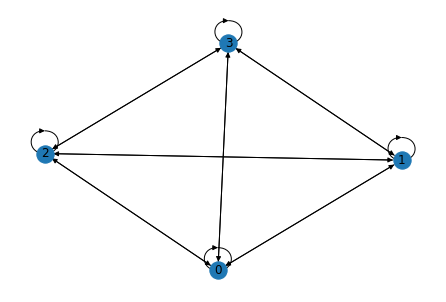

In [26]:
node_features = torch.tensor([[0, 0],
                              [1, 0],
                              [1, 1],
                              [0, 1]])

edge_index = radius_graph(
    node_features, r=2, batch=None, loop=True)

data = torch_geometric.data.Data(x=node_features, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=False, remove_self_loops=False)
# plt.figure()
nx.draw(g, with_labels=True)
plt.show()

See the shape of node features and edge features

In [9]:
data

Data(x=[4, 2], edge_index=[2, 16])

Beside these, you can look more into details about graph `data`.

In [14]:
print(data.keys)

['edge_index', 'x']


In [15]:
print(data['x'])

tensor([[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]])


In [16]:
print(data['edge_index'])

tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]])


In [19]:
for key, item in data:
    print(f'{key} found in data')
    print(f'{item} found in data')

x found in data
tensor([[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]]) found in data
edge_index found in data
tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]]) found in data


# Steps for Implementing Conservation of Mementum in GNS

## Shape of batch in GNS

Our `train.py` is a dictionary of "simulation_trajectories". Each has trajectory length of 320. The `data_loader_by_samples` samples a training examples ((positions, sequence of current 6 positions, dim), (next ground truth position)) for 2 batches

In [27]:
data_path = "../gns-data/datasets/sand-2d/"
ds = data_loader.get_data_loader_by_samples(path=f"{data_path}train.npz",
                                              input_length_sequence=6,
                                              batch_size=2,
                                              shuffle=False)

# length of ds is, (trajectory_length - 6)*(n_trajectory)/2
print(len(ds)) # 1413 =  (320-6)*9 / 2

# Look at the first 2 trajectory.
for i, ((position, particle_type, n_particles_per_example), labels) in enumerate(ds):
    if i == 1:
        break
    print(position.shape)  # torch.Size([12800, 6, 2])
    print(particle_type.shape)  # torch.Size([12800])
    print(n_particles_per_example.shape)  # torch.Size([2])
    print(n_particles_per_example)  # tensor([6400, 6400])
    print(labels.shape)  # torch.Size([12800, 2])
    print(i)

1413
torch.Size([12800, 6, 2])
torch.Size([12800])
torch.Size([2])
tensor([6400, 6400])
torch.Size([12800, 2])
0


## Play with similar artifitial batch

In [8]:
# As you can see, it is concatenated list of two batch
# Let's make try the similar array
node_features = [
    np.array([[x, y] for x in np.linspace(0, 1, 5) for y in np.linspace(0, 1, 5)]),
    np.array([[x, y] for x in np.linspace(1.5, 2.5, 10) for y in np.linspace(1.5, 2.5, 10)])
]
nparticles_per_example = [len(node_features[0]), len(node_features[1])]
node_features = np.concatenate(node_features)
radius = 1.2

# Batch_ids are the flattened ids (0 or 1) represents
# where the node features are come from which batch.
batch_ids = torch.cat(
    [torch.LongTensor([i for _ in range(n)]) for i, n in enumerate(nparticles_per_example)])

# radius_graph accepts r < radius not r <= radius
# A torch tensor list of source and target nodes with shape (2, nedges)
edge_index = radius_graph(
    torch.tensor(node_features), r=radius, batch=batch_ids, loop=True)
# edge_index = np.array(edge_index)

# sender and receiver
receiver = edge_index[0, :]
sender = edge_index[1, :]

/tmp/ipykernel_242378/491915402.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch_geometric.data.Data(x=torch.tensor(node_features), edge_index=torch.tensor(edge_index))


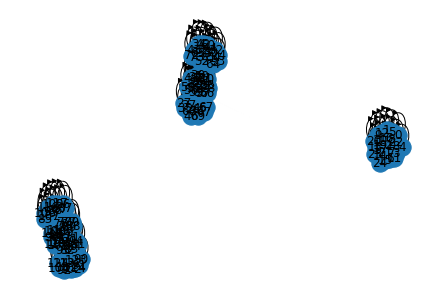

In [9]:
# Show graph connectivity plot
a = torch_geometric.data.Data(x=torch.tensor(node_features), edge_index=torch.tensor(edge_index))
g = torch_geometric.utils.to_networkx(a, to_undirected=False, remove_self_loops=False)
nx.draw(g, with_labels=True)
plt.show()

## Find edge index where sender==receiver

#### Loop algorithm to find sender==receiver

In [10]:
print(edge_index)

# Find edge index where sender==receiver
edge_index_inverted = torch.empty(edge_index.shape, dtype=torch.int64)
edge_index_inverted[[0, 1], :] = edge_index[[1, 0], :]

# Algorithm-1
graph_connectivity_indices = []
length = len(edge_index.T)
for i, sender2receiver in enumerate(edge_index.T):
    # if i < 5:
        for j, receiver2sender in enumerate(edge_index_inverted.T[i:]):
            if torch.equal(sender2receiver, receiver2sender):
                bidirectional_edge_id = i, j+i
                bidirectional_node_id = edge_index.T[i]
                graph_connectivity_index = bidirectional_edge_id, bidirectional_node_id
                graph_connectivity_indices.append(graph_connectivity_index)
print(i)
print(graph_connectivity_indices)

tensor([[  0,   1,  11,  ...,  98,  99, 115],
        [  0,   0,   0,  ..., 124, 124, 124]])
3804
[((0, 0), tensor([0, 0])), ((1, 22), tensor([1, 0])), ((2, 278), tensor([11,  0])), ((3, 253), tensor([10,  0])), ((4, 141), tensor([6, 0])), ((5, 117), tensor([5, 0])), ((6, 52), tensor([2, 0])), ((7, 172), tensor([7, 0])), ((8, 197), tensor([8, 0])), ((9, 222), tensor([9, 0])), ((10, 77), tensor([3, 0])), ((11, 101), tensor([4, 0])), ((12, 523), tensor([21,  0])), ((13, 501), tensor([20,  0])), ((14, 402), tensor([16,  0])), ((15, 378), tensor([15,  0])), ((16, 553), tensor([22,  0])), ((17, 433), tensor([17,  0])), ((18, 309), tensor([12,  0])), ((19, 334), tensor([13,  0])), ((20, 458), tensor([18,  0])), ((21, 359), tensor([14,  0])), ((23, 23), tensor([1, 1])), ((24, 279), tensor([11,  1])), ((25, 254), tensor([10,  1])), ((26, 142), tensor([6, 1])), ((27, 118), tensor([5, 1])), ((28, 53), tensor([2, 1])), ((29, 173), tensor([7, 1])), ((30, 198), tensor([8, 1])), ((31, 223), tensor([

In [12]:
As[0][1]

tensor([1, 0])

#### Another option for searching
The script removes repetitive arrays

In [11]:
edge_index

tensor([[1, 2, 0, 3, 0, 3, 1, 2, 5, 6, 4, 7, 4, 7, 5, 6],
        [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]])

In [26]:
sorted_edge_index = [i for i in map(sorted, edge_index.T.tolist())]
print(sorted_edge_index)
bidirectional_edge_id_try = []
for i, a in enumerate(sorted_edge_index):
    if a not in bidirectional_edge_id_try:
        bidirectional_edge_id_try.append(a)
bidirectional_edge_id_try

[[0, 1], [0, 2], [0, 1], [1, 3], [0, 2], [2, 3], [1, 3], [2, 3], [4, 5], [4, 6], [4, 5], [5, 7], [4, 6], [6, 7], [5, 7], [6, 7]]


[[0, 1], [0, 2], [1, 3], [2, 3], [4, 5], [4, 6], [5, 7], [6, 7]]

In [100]:
connected_nodes_2 = {tuple(i) for i in map(sorted, edge_index.T.tolist())}
print(list(connected_nodes_2))

for i, nodes in zip(bidirectional_edge_id, connected_nodes_2):
    print(i, nodes)

[(0, 1), (4, 6), (5, 7), (2, 3), (6, 7), (0, 2), (4, 5), (1, 3)]
tensor([0, 2]) (0, 1)
tensor([1, 4]) (4, 6)
tensor([3, 6]) (5, 7)
tensor([5, 7]) (2, 3)
tensor([ 8, 10]) (6, 7)
tensor([ 9, 12]) (0, 2)
tensor([11, 14]) (4, 5)
tensor([13, 15]) (1, 3)


Objective: find connected and non-connected edge ids, and compare messages
* Find connected edges and their IDs
*


In [68]:
print(edge_index)
print(edge_index_inverted)

tensor([[1, 2, 0, 3, 0, 3, 1, 2, 5, 6, 4, 7, 4, 7, 5, 6],
        [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]])
tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7],
        [1, 2, 0, 3, 0, 3, 1, 2, 5, 6, 4, 7, 4, 7, 5, 6]])
